In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../')))

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from tqdm.auto import tqdm

# Load data

## Returns

In [2]:
%%time
fret_df = pd.read_parquet(glob.glob('/mnt/e/data_links/HFZoo/proc/factor_returns_with_jumpind/hfzoo/*_all.parquet'))

CPU times: user 547 ms, sys: 5.05 s, total: 5.59 s
Wall time: 1.83 s


## Clusters

In [3]:
cluster_class_df = pd.read_feather("../../../../GitHub/HFZoo/data/keys/cluster_classifications.feather")
cluster_class_filter_df = cluster_class_df
# .query(
#     'factor.str.contains("jkp__")', engine="python"
# ).sort_values(by="Classification")
classification_order = [
    "Value",
    "Investment",
    "Low Risk",
    "Profitability",
    "Quality",
    "Leverage",
    "Momentum",
    "Size",
    "Profit Growth",
    "Accruals",
    "Debt Issuance",
    "Skewness",
    "Seasonality",
]
assign_alt_df = cluster_class_filter_df.assign(
        classification=pd.Categorical(
            cluster_class_filter_df["cluster_avg"], categories=classification_order, ordered=True
        )
    )
factor_order = (
    assign_alt_df
    .sort_values(by=["classification", "rho_avg"], ascending = [True, False])["factor"]
    .values
)

## Factor signs

In [4]:
# Get factor info from merged spreadsheet
factor_info_df = pd.read_csv('../../../../GitHub/HFZoo/docs/factor_cite_info.csv')

# Format factor names
factor_info_df[['Name in CZ', 'Name in JKP']] = factor_info_df[['Name in CZ', 'Name in JKP']].astype(str).replace('nan', ' ')
factor_info_df['cz_factor'] = np.where(
    ~(factor_info_df['Name in CZ'] == ' '),
    factor_info_df['Name in CZ'].apply(lambda x: 'cz__' + x.lower().replace('\\', '')),
    '')
factor_info_df['jkp_factor'] = np.where(
    ~(factor_info_df['Name in JKP'] == ' '),
    factor_info_df['Name in JKP'].apply(lambda x: 'jkp__' + x.lower().replace('\\', '')),
    '')

# Identify factors in both datasets
factor_info_df['factor_in_both_cz_jkp'] = (factor_info_df[['Name in JKP', 'Name in CZ']].applymap(len)-1).prod(axis = 1) > 0

In [5]:
factor_key_df = pd.DataFrame(fret_df.columns, columns=["factor_original"])
factor_key_df = factor_key_df.merge(
    factor_info_df[["jkp_factor", "JKP Classification", "Description", "Sign"]].rename(
        columns={"jkp_factor": "factor_original"}
    ),
    how="left",
    on="factor_original",
).merge(
    factor_info_df[["cz_factor", "CZ Classification", "Description", "Sign"]].rename(
        columns={"cz_factor": "factor_original"}
    ),
    how="left",
    on="factor_original",
)
factor_key_df["Classification"] = factor_key_df["JKP Classification"].fillna(
    factor_key_df["CZ Classification"]
)
factor_key_df = factor_key_df.drop(["JKP Classification", "CZ Classification"], axis=1)
factor_key_df["Description"] = factor_key_df["Description_y"].fillna(factor_key_df["Description_x"])
factor_key_df = factor_key_df.drop(["Description_x", "Description_y"], axis=1)
factor_key_df["Sign"] = factor_key_df["Sign_y"].fillna(factor_key_df["Sign_x"])
factor_key_df = factor_key_df.drop(["Sign_x", "Sign_y"], axis=1)
factor_key_df = factor_key_df.loc[
    factor_key_df["factor_original"].str.contains("jkp__")
    | factor_key_df["factor_original"].str.contains("cz__")
]

# Clean data

In [6]:
# Fix signs
for col in tqdm([x for x in fret_df.columns if 'jkp__' in x or 'cz__' in x]):
    fret_df[col] = fret_df[col]*factor_key_df.set_index('factor_original').loc[col,'Sign']

  0%|          | 0/218 [00:00<?, ?it/s]

In [61]:
# Focus on intradaily returns
fret_df = fret_df.loc[fret_df.index.time != dt.time(9,30)].sort_index()

# Construct heatmaps

## Compute autocorrs

In [62]:
## Compute correaltion measures
# Total realized variance
realized_var_sum = fret_df.T @ fret_df

# Diagonal of realized variance sum
realized_var_sum_diag = pd.DataFrame(np.diag(realized_var_sum), index = fret_df.columns)

# Each entry is sigma_i * sigma_j for assets (i,j)
realized_var_prod_sum = (realized_var_sum_diag @ realized_var_sum_diag.T).pipe(np.sqrt)

# Realized correlation
realized_corr =  (fret_df.T @ fret_df) / realized_var_prod_sum

# Lagged versus contemporaneous -- total rv
cross_auto_realized_cov_sum = fret_df.shift(1).fillna(0).T @ fret_df

# Realized cross-autocorrelations
cross_auto_realized_corr = cross_auto_realized_cov_sum / realized_var_prod_sum

# Other correlations
cross_auto_realized_corr_2 = (fret_df.shift(2).fillna(0).T @ fret_df) / realized_var_prod_sum
cross_auto_realized_corr_3 = (fret_df.shift(3).fillna(0).T @ fret_df) / realized_var_prod_sum
cross_auto_realized_corr_4 = (fret_df.shift(4).fillna(0).T @ fret_df) / realized_var_prod_sum

## Plot

In [63]:
# Color map
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name="test", 
    # colors=["blue", '#99caff', '#d4e7fc',  'white',  '#fcd4d4',  '#ff6666', "red"], N=20000
    colors=[(0, "blue"), (0.45, "lightsteelblue"), (0.5, "white"), (0.55, "lightcoral"), (1, "red")], N=20000
    # colors=["blue", "lightsteelblue", "white", "lightcoral", "red"], N=20000
)

In [89]:
## Functions for labelling heatmaps
from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos+ .2], [xpos, xpos], color=(0,0,0,0.5), transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, fontsize = 12):
    xpos = -.2
    scale = 1./df.index.size
    for level in range(df.index.nlevels-1):
        pos = df.index.size
        for label, rpos in label_len(df.index,level):
            add_line(ax, pos*scale, xpos-0.005)
            pos -= rpos
            lypos = (pos + .4 * rpos)*scale
            fontsize_adj = fontsize + 0.15*(rpos)
            ax.text(xpos+.1, lypos, label, ha='center', va = 'center', 
                    fontsize = fontsize_adj, transform=ax.transAxes) 
        add_line(ax, pos*scale , xpos)
        xpos -= .2

In [90]:
def plot_cluster_heatmap(plot_df, fig, ax, use_cbar=True, fontsize = 12):

    ## Cross auto-correlations
    fmt = lambda x, pos: "{:.0%}".format(x)
    heatmap = sns.heatmap(
        plot_df.loc[factor_order, factor_order],
        cmap=custom_cmap,
        xticklabels=[],
        yticklabels=[],
        linewidths=0,
        linecolor="black",
        alpha=0.5,
        center=0,
        vmax=1,
        vmin=-1,
        cbar=use_cbar,
        cbar_kws={"format": mpl.ticker.FuncFormatter(fmt), "location": "left"},
        ax=ax,
    )

    # Make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # Index correlations with classification
    corr_class = (
        plot_df.T.loc[factor_order]
        .reset_index()
        .rename(columns={"index": "factor"})
        .merge(assign_alt_df[["classification", "factor"]], on=["factor"])
        .set_index(["classification", "factor"])
        .sort_index()
    )
    label_group_bar_table(ax, corr_class, fontsize = fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=45)

    return fig, ax

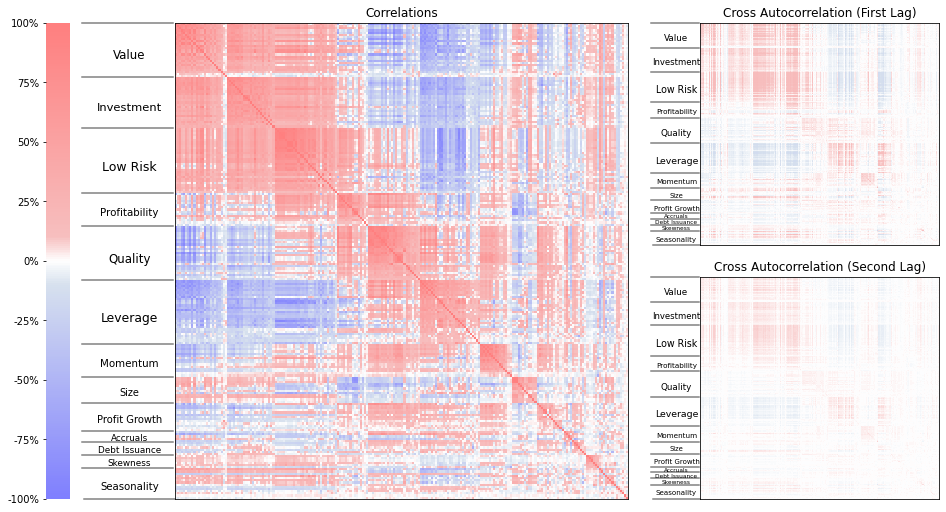

In [98]:
gs_kw = dict(width_ratios=[1.9, 1], height_ratios=[1, 1], wspace=0.05)
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              gridspec_kw=gs_kw,
                              figsize=(13, 7), constrained_layout=True)

_, ax = plot_cluster_heatmap(realized_corr, fig, axd['left'], fontsize = 8)
ax.set_title('Correlations')
_, ax = plot_cluster_heatmap(cross_auto_realized_corr, fig, axd['upper right'], use_cbar = False, fontsize = 5)
ax.set_title('Cross Autocorrelation (First Lag)')
_, ax = plot_cluster_heatmap(cross_auto_realized_corr_2, fig, axd['lower right'], use_cbar = False, fontsize = 5)
ax.set_title('Cross Autocorrelation (Second Lag)')

fig.savefig('../../docs/exhibits/figures/correlations_heatmap.pdf')